In [32]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

#### 题目2
模拟退火算法求解系统最低的能量态

对于系统初值的选取,这里随手选取了T=2000
算法流程大致如下：
```
1、初始化
    根据随机均匀分布生成系统的初始能量态；
    计算系统初值能量；
2、循环体
    while(冷却温度T>设定冷却停止温度Tf):
        for i=1 to N(单次冷却温度中最大迭代次数):
            给定温度生成符合要求的新状态；
            计算接受状态概率；
            生成随机数，判断状态转移并转移到下一个状态；
        T=alpha(冷却速率)*T
```

In [33]:
'''
Author: loyunemo 3210100968@zju.edu.cn
Date: 2023-11-26 16:43:25
LastEditors: loyunemo 3210100968@zju.edu.cn
LastEditTime: 2023-11-27 19:18:20
FilePath: \Repo_Computer_Simulation\Hw9\Hw9.ipynb
Description: 这是默认设置,请设置`customMade`, 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE 
'''
def deltaE(r1,r2):
    r=abs(r1-r2)
    if r==0:
        return 0
    else:
        deltae=4000*(math.pow(0.1/r,12)-math.pow(0.1/r,6))
        return deltae
class system():
    def __init__(self):
        self.x_vector=np.random.uniform(-1,1,4)
        self.EnergySum=self.Energy()
    def Renew(self):
        self.x_vector=np.random.uniform(-1,1,4)
        self.EnergySum=self.Energy()
    def disturb(self,T,Iteration):
        for a in range(Iteration):
            disturb_place=random.randint(0,3)
            disturb_new=random.normalvariate(0,0.2)
            while(disturb_new>1 or disturb_new<-1):
                disturb_new=random.normalvariate(0,0.2)
            newx=np.copy(self.x_vector)
            newx[disturb_place]=disturb_new
            Energynew=0
            for t in range(newx.shape[0]):
                for u in range(t):
                    Energynew+=self.deltaE(newx[t],newx[u])
            h=min(1,math.exp(-(Energynew-self.EnergySum)/T))
            accept=random.uniform(0,1)
            if accept<h:
                self.x_vector=newx
                self.EnergySum=self.Energy()    
    def Energy(self):
        Energysum=0
        for t in range(self.x_vector.shape[0]):
            for u in range(t):
                Energysum+=self.deltaE(self.x_vector[t],self.x_vector[u])
        return Energysum
    def deltaE(self,r1,r2):
        r=abs(r1-r2)
        deltae=4000*(math.pow(0.1/r,12)-math.pow(0.1/r,6))
        return deltae
    def Metropolis_Annealing(self,StartTemperature,CoolRate,maxIter,StopTemperature): 
        T=StartTemperature
        while(T>=StopTemperature):
            self.disturb(T,maxIter)
            T=CoolRate*T
def Estimate():
    num=100000
    aver=np.zeros(num)

    for t in range(num):
        E1=random.normalvariate(0,0.2)
        while(E1>1 or E1<-1):
            E1=random.normalvariate(0,0.2)
        E2=random.normalvariate(0,0.2)
        while(E2>1 or E2<-1):
            E2=random.normalvariate(0,0.2)

        
        aver[t]=E1-E2
    EnergyEstimate=np.mean(aver)
    return EnergyEstimate
Eg1=system()
Eg1.Metropolis_Annealing(2000,0.89,400,0.04)
Eg2=system()
Eg2.Metropolis_Annealing(2000,0.89,400,0.08)
print("T_Stop=0.04: ",Eg1.EnergySum)
print("T_Stop=0.08: ",Eg2.EnergySum)

T_Stop=0.04:  -3064.9560290415675
T_Stop=0.08:  -3064.8909352570417


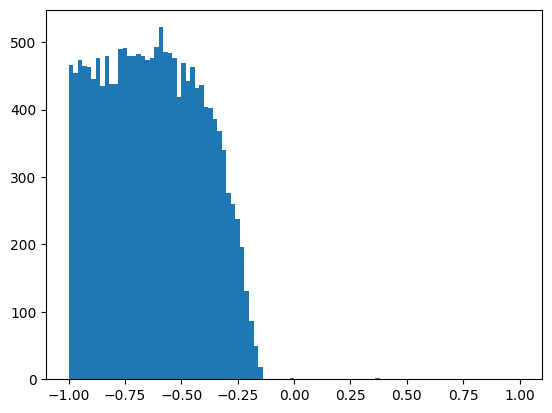

In [34]:
num=1000000
x=np.zeros(num)
for t in range(num):
    q=system()
    x[t]=q.EnergySum
plt.hist(x,100,[-1,1])
plt.show()

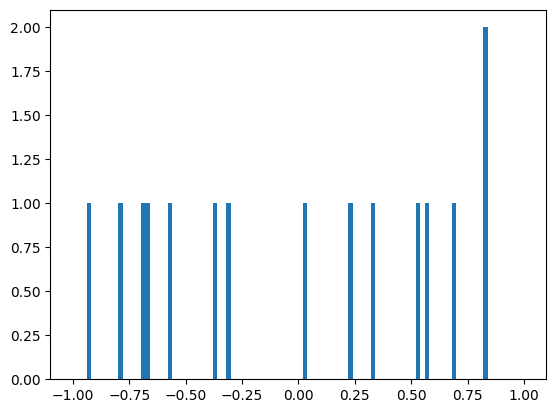

In [35]:
num=1000000
x=np.zeros(num)
for t in range(num):
    q=system()
    for z in range(q.x_vector.shape[0]):
        q.x_vector[z]=random.normalvariate(0,0.2)
        while(q.x_vector[z]>1 or q.x_vector[z]<-1):
            q.x_vector[z]=random.normalvariate(0,0.2)
    q.EnergySum=q.Energy()
    x[t]=q.EnergySum
plt.hist(x,100,[-1,1])
plt.show()

#### 题目3
模拟退火求解旅行商问题,
首先需要对距离进行估计，估计退火初始温度$T_0$

In [36]:
CitiesMatrix=np.array([[12,12],[18,23],[24,21],[29,25],[31,52],[36,43],[37,14],[42,8],[51,47],[62,53],[63,19],[69,39],[81,7],[82,18],[83,40],[88,30]])
def dis_between(a,b):
    return np.sqrt(np.dot(a-b,a-b))
def discal(CitiesMatrix,rank):
    DisSum=0
    for t in range(rank.shape[0]-1):
        DisSum+=dis_between(CitiesMatrix[rank[t]],CitiesMatrix[rank[t+1]])
    return DisSum
Trialnum=10000
distance=0
for t in range(Trialnum):
# 随机打乱列表
    rank = np.array(list(range(0, 16)))
    random.shuffle(rank)
    distance+=discal(CitiesMatrix,rank)
ave_dis=distance/Trialnum
print(ave_dis)


573.0273425436


在这里$E_0$大约在571左右，
考虑：
$0.99=e^{-\frac{571}{T}}$
计算得到：
T=56814,取56000即可。

接下来根据模拟算法计算旅行商问题,每次随机选择路径进行逆转，根基Metropolis算法进行判断并接受

In [38]:
def TSP_TemperatureIteration(CitiesMatrix,rank,Iteration,T):
    ranknow=rank
    for t in range(Iteration):
        start=random.randint(0,15)
        end=random.randint(1,16)
        while(end<=start):
            end=random.randint(1,16)
        reverge=ranknow[start:end][::-1]
        ranknew=ranknow.copy()
        ranknew[start:end]=reverge
        dis=discal(CitiesMatrix,ranknew)
        h=min(1,math.exp(-(dis-discal(CitiesMatrix,ranknow))/T))
        u=random.uniform(0,1)
        if u<h:
            ranknow=ranknew
    return ranknow
def Simulate_Annealing_TSP(CitiesMatrix,StartTemperature,EndTemperature,Iteration,CoolRate,WriteList):
    rank = np.array(list(range(0, 16)))
    random.shuffle(rank)
    T=StartTemperature
    while(T>=EndTemperature):
        #print("Temperature: ",T," Distance:",discal(CitiesMatrix,rank))
        rank=TSP_TemperatureIteration(CitiesMatrix,rank,Iteration,T)
        WriteList.append(rank)
        T*=CoolRate
    return rank
Writelist=[]
rankresult=Simulate_Annealing_TSP(CitiesMatrix,56000,0.01,1600,0.85,Writelist)


[4, 5, 8, 9, 11, 14, 15, 13, 12, 10, 7, 6, 3, 2, 1, 0] 195.68923304678708


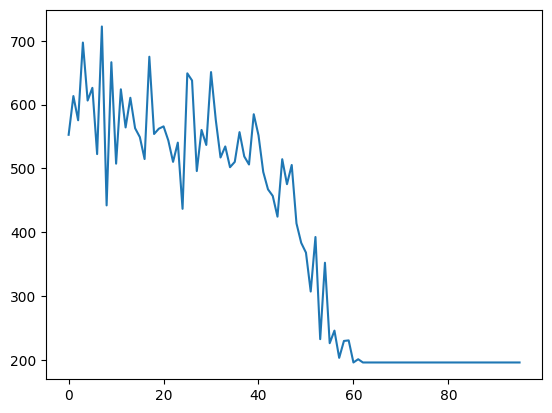

In [39]:
distancelist=np.zeros(len(Writelist))
for t in range(len(Writelist)):
    distancelist[t]=discal(CitiesMatrix,Writelist[t])
print(rankresult.tolist(),discal(CitiesMatrix,rankresult))
plt.plot(np.arange(0,len(Writelist)),distancelist)
plt.show()

#### 题目6 
最小二乘法拟合人口数据

Optimized Parameters: (array([1.60827563e-11, 2.27034749e-02, 3.87967978e+08]), 1)


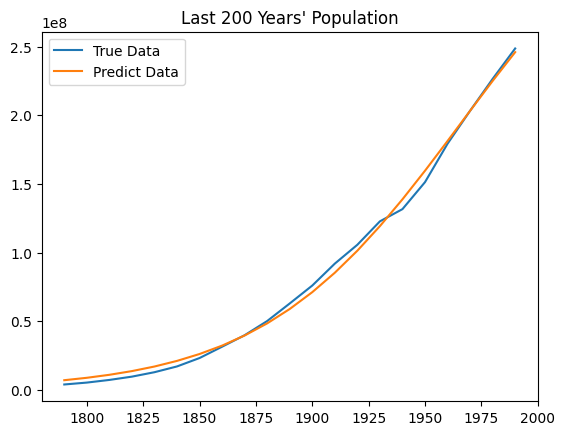

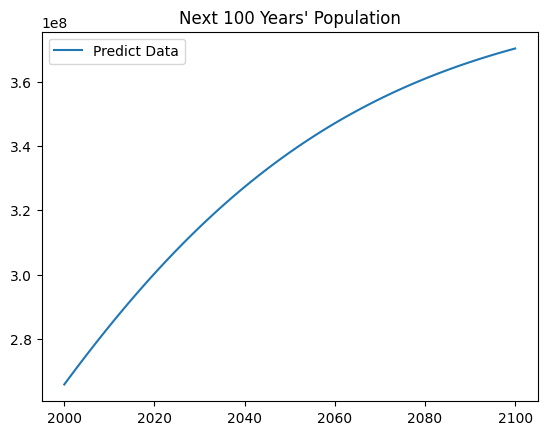

In [76]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import leastsq
# 定义模型函数
import warnings

warnings.filterwarnings('ignore')
def model_function(params, t):

    A, r, K = params
    return A*K*np.exp(r*t)/(K+A*np.exp(r*t))

# 定义目标函数（残差平方和）
def objective_function(params, x, y_observed):
    return y_observed - model_function(params, x)

# 生成一些模拟数据

x_data = np.linspace(1790,1990,21).flatten()

y_data = np.array([3929214,5308483,7239881,9638453,12866020,17069453,23191876,31433321,39818449,50155783,62947714,75994575,91972266,105710620,122775046,131669275,151325798,179323175,203302031,226545805,248709873]).flatten()
# 初始化参数猜测
initial_guess = [1.60826987e-11, 2.27034768e-02, 3.87967929e+08]

# 使用leastsq进行非线性最小二乘法拟合
optimized_params=leastsq(objective_function, initial_guess, args=(x_data, y_data))
#print(optimized_params)
for t in range(100):
    optimized_params=leastsq(objective_function, optimized_params[0], args=(x_data, y_data))

print("Optimized Parameters:", optimized_params)
predict=model_function(optimized_params[0],x_data)

plt.plot(x_data,y_data,label="True Data")
plt.plot(x_data,predict,label="Predict Data")
plt.title("Last 200 Years' Population")
plt.legend()
plt.show()
next=np.linspace(2000,2100,101)
predictnew=model_function(optimized_params[0],next)

plt.plot(next,predictnew,label="Predict Data")
plt.title("Next 100 Years' Population")
plt.legend()
plt.show()